# Type 2 Diabetes Detection from Microbiome Data

This notebook builds a course-aligned preprocessing workflow for microbiome data and demonstrates how to move from raw abundance tables to model-ready representations.

### Goals
- Inspect raw data structure and sparsity.
- Apply **MIPMLP-inspired preprocessing** (prevalence filtering, log transform, subPCA by taxonomy groups).
- Visualize each preprocessing step, including **before/after log transform**.
- Show **raw shape vs post-subPCA shape**.
- Train baseline classifiers and interpret outputs with medically relevant metrics.


## Workflow Roadmap

1. Load data and define target labels.
2. Explore raw microbiome characteristics (composition, sparsity, prevalence).
3. Build preprocessing tools (prevalence filter + MIPMLP subPCA).
4. Apply leakage-safe preprocessing (fit on train only, transform test).
5. Compare representations with visualization and baseline models.

All code cells are written to be copy-ready for the Methods section of the project report.


In [7]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
)

from IPython.display import display

SEED = 42
np.random.seed(SEED)

sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (10, 6)


## 1. Load Data and Define Prediction Target

We keep the full multiclass label (`healthy`, `IGT`, `T2D`) for descriptive analysis.
For baseline modeling, we start with a clinically practical binary target:

- `1`: T2D
- `0`: non-T2D (`healthy` + `IGT`)

This can later be extended to multiclass modeling.


In [8]:
DATA_PATH = "T2D_microbiome_dataset.csv"

df = pd.read_csv(DATA_PATH)
feature_cols = [c for c in df.columns if c != "label"]

X_raw = df[feature_cols].copy()
y_multiclass = df["label"].copy()
y_binary = (y_multiclass == "T2D").astype(int)

print(f"Raw data shape (samples, features): {X_raw.shape}")
print("\nMulticlass label counts:")
display(y_multiclass.value_counts().rename_axis("label").to_frame("count"))

print("Preview of first 3 samples:")
display(df.head(3))


Raw data shape (samples, features): (145, 498)

Multiclass label counts:


,count
label,
T2D,53
IGT,49
healthy,43


Preview of first 3 samples:


,species:Faecalibacterium prausnitzii,species:Dorea longicatena,species:Fusicatenibacter saccharivorans,species:Blautia obeum,species:Coprococcus comes,species:Bacteroides uniformis,species:Collinsella aerofaciens,species:Bifidobacterium adolescentis,species:[Ruminococcus] torques,species:[Eubacterium] rectale,...,species:Raoultella ornithinolytica,species:Kluyvera cryocrescens,species:Raoultella planticola,species:Kluyvera ascorbata,species:Lactococcus raffinolactis,species:Prevotella sp. 885,species:Anaeromassilibacillus sp. An172,species:Corynebacterium glutamicum,species:Subdoligranulum variabile,label
0,16.77088,8.86025,7.79429,7.34667,6.47102,5.74062,5.61847,4.15568,4.08278,2.49154,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,IGT
1,4.68705,2.68031,1.37876,0.26129,0.27289,1.73862,0.27524,0.48050,0.24181,0.58563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,healthy
2,12.09206,3.05321,3.40659,0.26809,1.17859,1.69510,2.11810,2.41923,0.92541,0.00454,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,healthy


### How to read this output

- `shape`: number of patient samples and taxa features.
- `label counts`: class balance; this affects train/test split strategy and evaluation metrics.
- Preview confirms taxonomy-like column naming (`species:...`, `genus:...`) and a final `label` column.


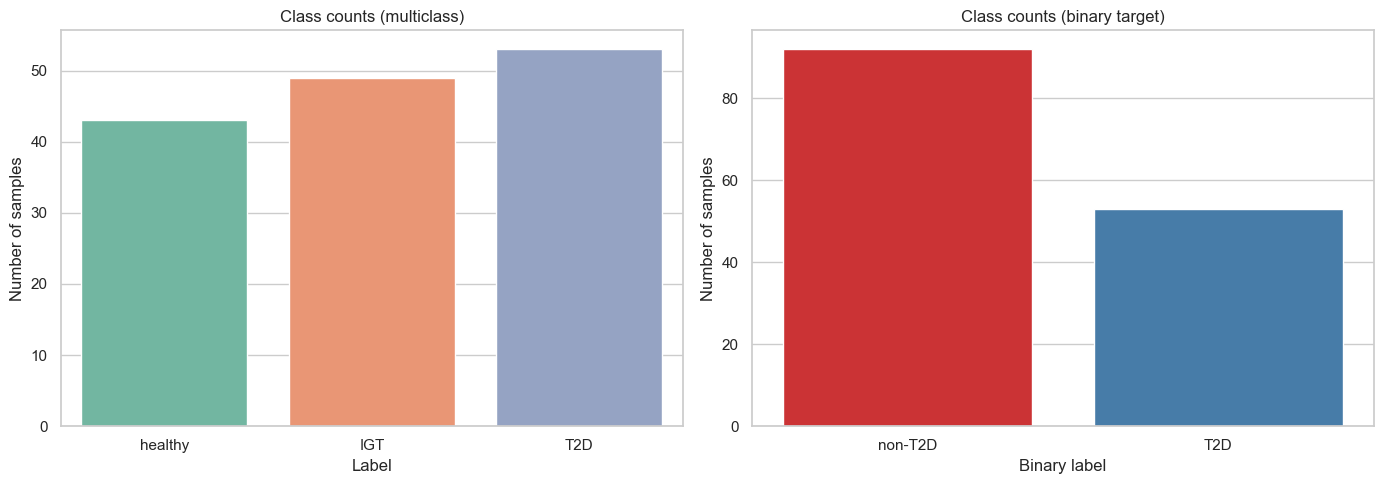

In [9]:
label_order = ["healthy", "IGT", "T2D"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.countplot(x=y_multiclass, order=label_order, palette="Set2", ax=axes[0])
axes[0].set_title("Class counts (multiclass)")
axes[0].set_xlabel("Label")
axes[0].set_ylabel("Number of samples")

binary_counts = pd.Series(np.where(y_binary == 1, "T2D", "non-T2D")).value_counts()
sns.barplot(x=binary_counts.index, y=binary_counts.values, palette="Set1", ax=axes[1])
axes[1].set_title("Class counts (binary target)")
axes[1].set_xlabel("Binary label")
axes[1].set_ylabel("Number of samples")

plt.tight_layout()
plt.show()


## 2. Raw Microbiome Diagnostics

Microbiome tables are typically sparse, compositional, and high-dimensional.
We verify those assumptions before applying any transform.


Row sum min / median / max: 97.329 / 99.938 / 100.000
Global zero fraction: 0.800
Features present in <10% of samples: 289 / 498


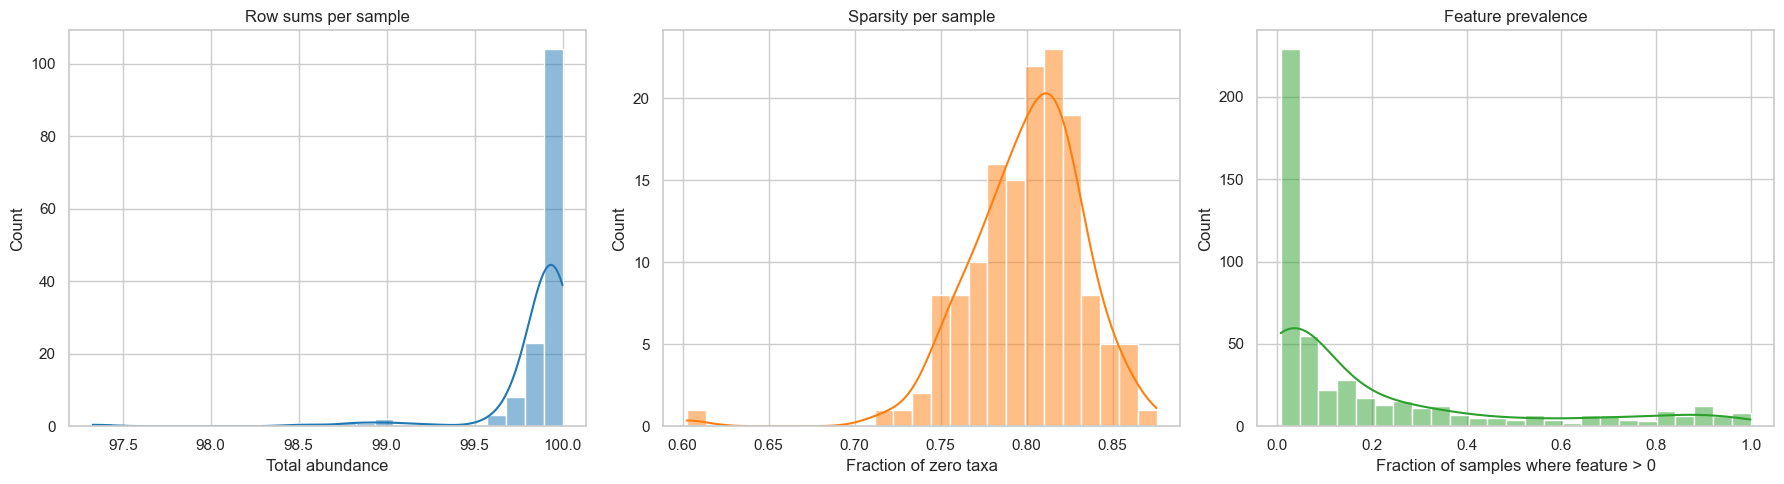

In [10]:
row_sums = X_raw.sum(axis=1)
sample_zero_fraction = (X_raw == 0).mean(axis=1)
feature_prevalence = (X_raw > 0).mean(axis=0)
feature_mean = X_raw.mean(axis=0)

print(f"Row sum min / median / max: {row_sums.min():.3f} / {row_sums.median():.3f} / {row_sums.max():.3f}")
print(f"Global zero fraction: {(X_raw == 0).mean().mean():.3f}")
print(f"Features present in <10% of samples: {(feature_prevalence < 0.10).sum()} / {X_raw.shape[1]}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(row_sums, bins=25, kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Row sums per sample")
axes[0].set_xlabel("Total abundance")

sns.histplot(sample_zero_fraction, bins=25, kde=True, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Sparsity per sample")
axes[1].set_xlabel("Fraction of zero taxa")

sns.histplot(feature_prevalence, bins=25, kde=True, ax=axes[2], color="#2ca02c")
axes[2].set_title("Feature prevalence")
axes[2].set_xlabel("Fraction of samples where feature > 0")

plt.tight_layout()
plt.show()


### Interpretation notes

- Row sums close to the same value suggest relative abundance-style data.
- High zero fraction supports using prevalence filtering before modeling.
- Prevalence histogram helps choose a threshold (here we use `>=10%` in train set).


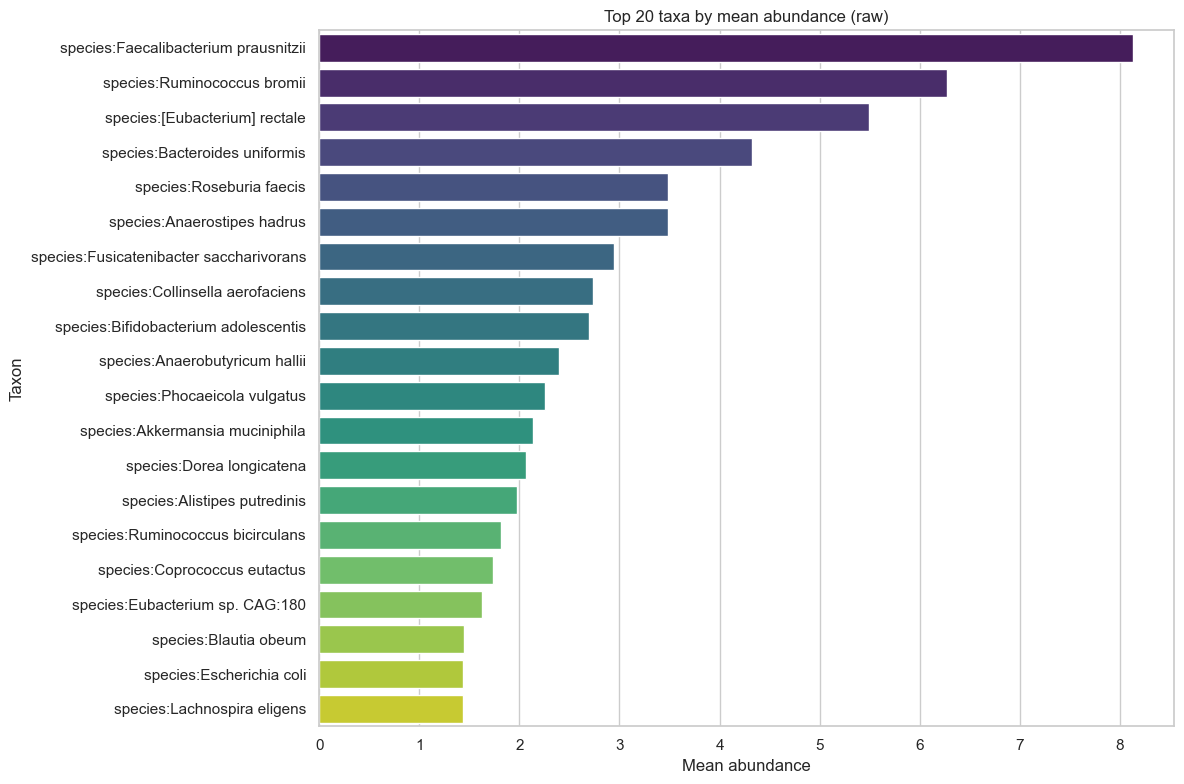

In [11]:
top_taxa = feature_mean.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_taxa.values, y=top_taxa.index, palette="viridis")
plt.title("Top 20 taxa by mean abundance (raw)")
plt.xlabel("Mean abundance")
plt.ylabel("Taxon")
plt.tight_layout()
plt.show()
